In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar el conjunto de datos de pasajeros de aerolíneas
series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
series['Month'] = pd.to_datetime(series['Month'])
series.set_index('Month', inplace=True)

# Visualizar los primeros datos
print(series.head())



            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


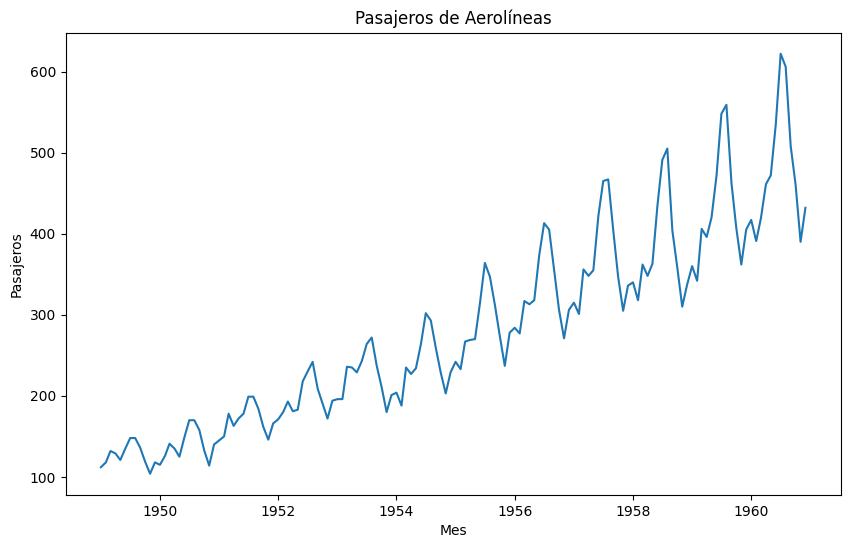

In [2]:
# Visualizar los datos de pasajeros de aerolíneas
plt.figure(figsize=(10, 6))
plt.plot(series.index, series['Passengers'])
plt.title('Pasajeros de Aerolíneas')
plt.xlabel('Mes')
plt.ylabel('Pasajeros')
plt.savefig('airline.png')
plt.show()

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Convertir una serie de tiempo en un problema de aprendizaje supervisado.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Aplicar la función a la serie de pasajeros
supervised = series_to_supervised(series.values, n_in=3)
print(supervised.head())


   var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
3      112.0      118.0      132.0      129
4      118.0      132.0      129.0      121
5      132.0      129.0      121.0      135
6      129.0      121.0      135.0      148
7      121.0      135.0      148.0      148


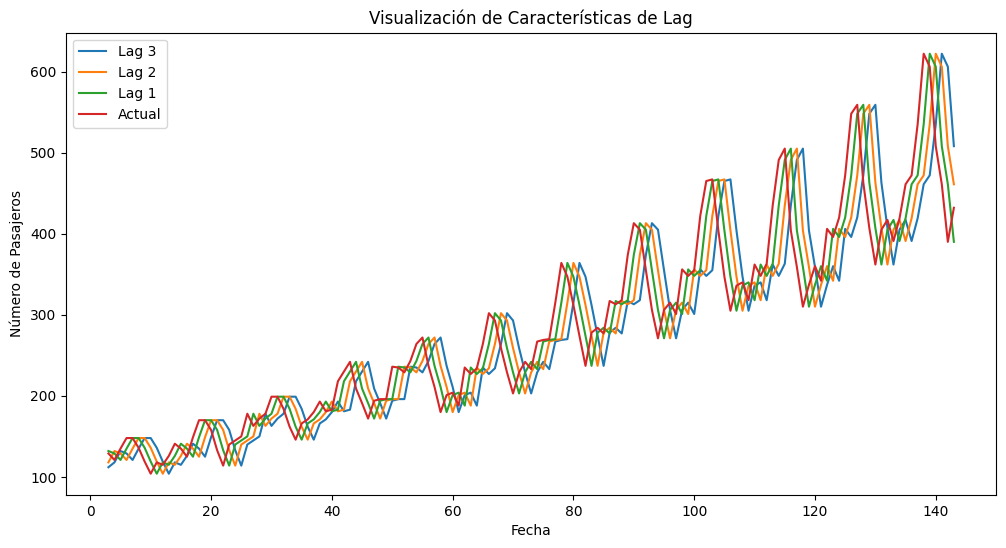

In [4]:
import matplotlib.pyplot as plt

# Visualizar las primeras filas del DataFrame transformado
plt.figure(figsize=(12, 6))
plt.plot(supervised.iloc[:, 0], label='Lag 3')
plt.plot(supervised.iloc[:, 1], label='Lag 2')
plt.plot(supervised.iloc[:, 2], label='Lag 1')
plt.plot(supervised.iloc[:, -1], label='Actual')
plt.title('Visualización de Características de Lag')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.legend()
plt.show()


In [5]:
# Dividir los datos en entrenamiento y prueba (80% - 20%)
train_size = int(len(supervised) * 0.8)
train, test = supervised.values[:train_size], supervised.values[train_size:]

# Separar las entradas (X) y las salidas (y)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print("Entrenamiento X shape:", train_X.shape)
print("Entrenamiento y shape:", train_y.shape)
print("Prueba X shape:", test_X.shape)
print("Prueba y shape:", test_y.shape)


Entrenamiento X shape: (112, 3)
Entrenamiento y shape: (112,)
Prueba X shape: (29, 3)
Prueba y shape: (29,)




### Hipótesis

En el contexto de forecasting con regresión lineal para series temporales, la hipótesis básica es que el valor futuro de la serie temporal $ y_t $ puede ser predicho utilizando información de valores pasados $ y_{t-1}, y_{t-2}, \ldots, y_{t-p} $, donde $ p $ es el número de pasos anteriores (lags) considerados.

La hipótesis se expresa como:

$$ y_t \approx \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2} + \ldots + \beta_p y_{t-p} + \epsilon_t $$

Donde:
- $ y_t $ es el valor actual de la serie temporal que queremos predecir.
- $ \beta_0, \beta_1, \ldots, \beta_p $ son los coeficientes del modelo que queremos estimar.
- $ y_{t-1}, y_{t-2}, \ldots, y_{t-p} $ son los valores pasados de la serie temporal.
- $ \epsilon_t $ es el término de error, que captura el ruido o la variabilidad no explicada por el modelo.

### Planteamiento

1. **Datos de entrenamiento**: Selecciona una ventana de datos históricos $ \{ y_{t-p}, y_{t-1}, y_t \} $ para cada período de tiempo $ t $ en tu serie temporal. Estos datos se utilizarán para estimar los coeficientes del modelo.

2. **Matriz de diseño**: Para aplicar regresión lineal, organiza los datos en una matriz de diseño $ X $ y un vector objetivo $ y $:
   - **Matriz de diseño $ X $**: Cada fila representa un período de tiempo $ t $ con las variables explicativas (lags) $ [y_{t-1}, y_{t-2}, \ldots, y_{t-p}] $.
   - **Vector objetivo $ y $**: Contiene los valores de la serie temporal $ y_t $ correspondientes.

3. **Estimación de coeficientes**: Utiliza técnicas de optimización (como mínimos cuadrados) para estimar los coeficientes $ \beta = [\beta_0, \beta_1, \ldots, \beta_p] $ que minimizan la suma de los cuadrados de los errores $ \epsilon_t $.

### Solución

La solución del modelo de regresión lineal se basa en encontrar los coeficientes $ \beta $ que mejor ajustan los datos históricos disponibles. Matemáticamente, se puede expresar como:

$$ \hat{\beta} = (X^T X)^{-1} X^T y $$

Donde:
- $ \hat{\beta} $ es el vector de coeficientes estimados.
- $ X^T $ es la matriz transpuesta de $ X $.
- $ (X^T X)^{-1} $ es la inversa de la matriz producto de $ X^T $ por $ X $.
- $ y $ es el vector de valores objetivo (la serie temporal en el período $ t $).



4. **Predicción**:
   - Una vez que tenemos $ \hat{\beta} $, podemos usarlo para predecir el número de pasajeros del próximo mes $ \hat{y}_{t+1} $ utilizando la fórmula del modelo lineal: $ \hat{y}_{t+1} = \beta_0 + \beta_1 y_t + \beta_2 y_{t-1} + \ldots + \beta_p y_{t-p+1} $.



RMSE en conjunto de entrenamiento: 25.17948988400745
RMSE en conjunto de prueba: 47.542491394731


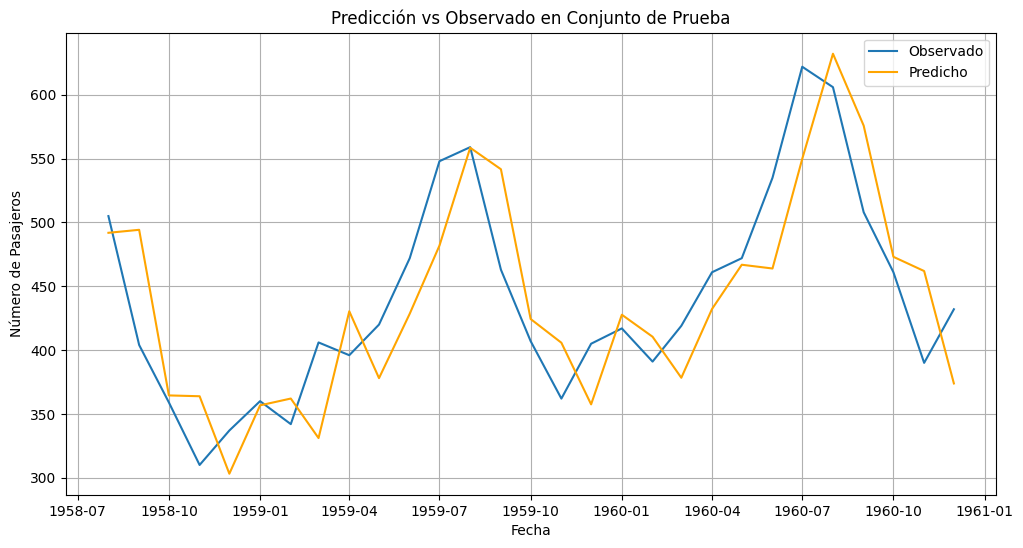

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(train_X, train_y)

# Hacer predicciones
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

# Evaluar el modelo
train_rmse = np.sqrt(mean_squared_error(train_y, train_pred))
test_rmse = np.sqrt(mean_squared_error(test_y, test_pred))

print("RMSE en conjunto de entrenamiento:", train_rmse)
print("RMSE en conjunto de prueba:", test_rmse)

# Plot de las predicciones
plt.figure(figsize=(12, 6))
plt.plot(series.index[-len(test):], test_y, label='Observado')
plt.plot(series.index[-len(test):], test_pred, label='Predicho', color='orange')
plt.title('Predicción vs Observado en Conjunto de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.legend()
plt.grid(True)
plt.show()


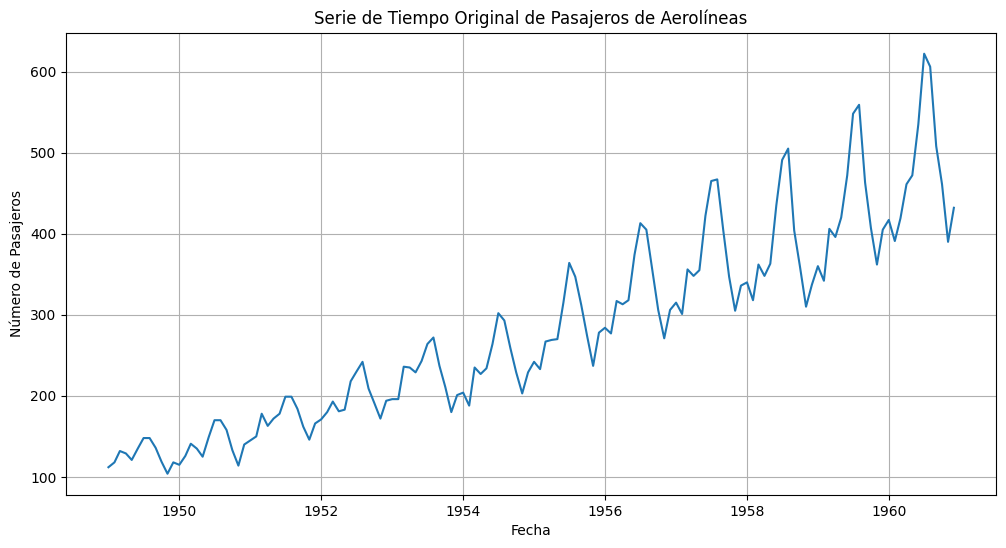

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Cargar el conjunto de datos de pasajeros de aerolíneas
series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
series['Month'] = pd.to_datetime(series['Month'])
series.set_index('Month', inplace=True)

# Visualizar la serie original
plt.figure(figsize=(12, 6))
plt.plot(series)
plt.title('Serie de Tiempo Original de Pasajeros de Aerolíneas')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.grid(True)
plt.show()


<Figure size 1200x600 with 0 Axes>

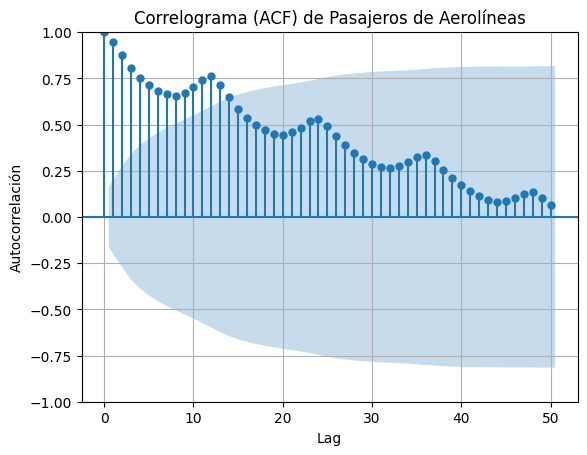

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot de autocorrelación
plt.figure(figsize=(12, 6))
plot_acf(series['Passengers'], lags=50)
plt.title('Correlograma (ACF) de Pasajeros de Aerolíneas')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.grid(True)
plt.show()


In [9]:


# Convertir la serie en un problema supervisado con 12 lags
n_lags = 12
supervised = series_to_supervised(series.values, n_in=n_lags)
print(supervised.head())


    var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  \
12       112.0       118.0       132.0      129.0      121.0      135.0   
13       118.0       132.0       129.0      121.0      135.0      148.0   
14       132.0       129.0       121.0      135.0      148.0      148.0   
15       129.0       121.0       135.0      148.0      148.0      136.0   
16       121.0       135.0       148.0      148.0      136.0      119.0   

    var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)  
12      148.0      148.0      136.0      119.0      104.0      118.0      115  
13      148.0      136.0      119.0      104.0      118.0      115.0      126  
14      136.0      119.0      104.0      118.0      115.0      126.0      141  
15      119.0      104.0      118.0      115.0      126.0      141.0      135  
16      104.0      118.0      115.0      126.0      141.0      135.0      125  


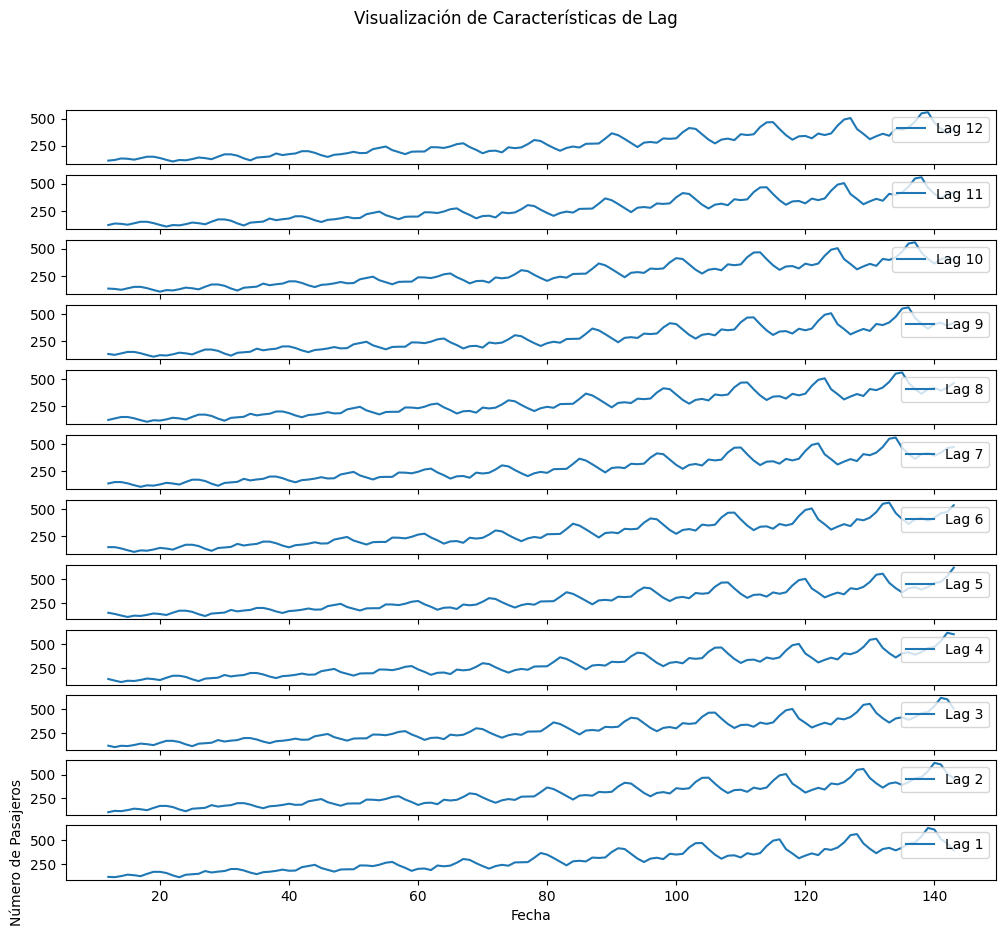

In [10]:
plt.figure(figsize=(12, 10))

for i in range(n_lags):
    plt.subplot(n_lags, 1, i+1)
    plt.plot(supervised.iloc[:, i], label=f'Lag {n_lags-i}')
    plt.legend(loc='upper right')

plt.suptitle('Visualización de Características de Lag')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.show()

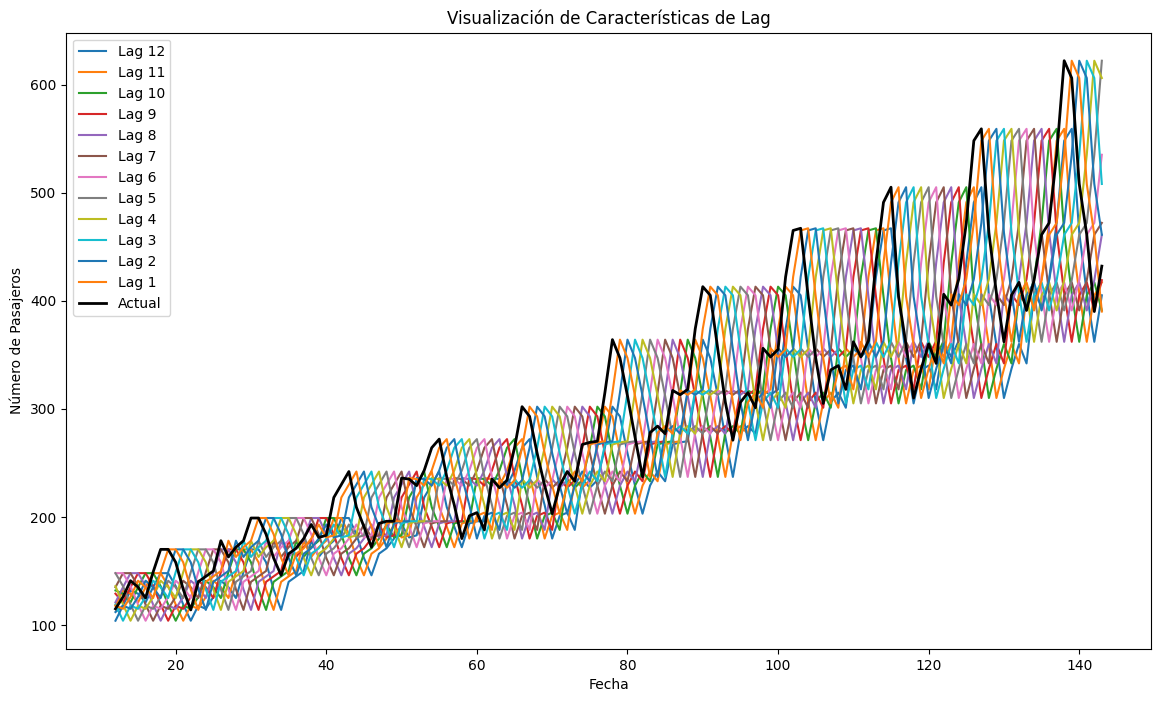

In [11]:
# Visualizar todas las características de lag en un solo gráfico
plt.figure(figsize=(14, 8))
for i in range(n_lags):
    plt.plot(supervised.index, supervised.iloc[:, i], label=f'Lag {n_lags-i}')

plt.plot(supervised.index, supervised.iloc[:, -1], label='Actual', linewidth=2, color='black')
plt.title('Visualización de Características de Lag')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.legend()
plt.show()

In [12]:
# Dividir los datos en entrenamiento y prueba (80% - 20%)
train_size = int(len(supervised) * 0.8)
train, test = supervised.values[:train_size], supervised.values[train_size:]

# Separar las entradas (X) y las salidas (y)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print("Entrenamiento X shape:", train_X.shape)
print("Entrenamiento y shape:", train_y.shape)
print("Prueba X shape:", test_X.shape)
print("Prueba y shape:", test_y.shape)


Entrenamiento X shape: (105, 12)
Entrenamiento y shape: (105,)
Prueba X shape: (27, 12)
Prueba y shape: (27,)


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Modelos y Evaluación
models = {
    "Linear Regression": LinearRegression(),
    "Perceptron": Perceptron(max_iter=1000),  # Ajusta max_iter según sea necesario
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100)
}

results = {}
for name, model in models.items():
    model.fit(train_X, train_y)
    train_pred = model.predict(train_X)
    test_pred = model.predict(test_X)
    results[name] = {
        "train_rmse": np.sqrt(mean_squared_error(train_y, train_pred)),
        "test_rmse": np.sqrt(mean_squared_error(test_y, test_pred)),
        "train_mae": mean_absolute_error(train_y, train_pred),
        "test_mae": mean_absolute_error(test_y, test_pred)
    }

# Mostrar los resultados
for name, metrics in results.items():
    print(f"{name} - RMSE en conjunto de entrenamiento: {metrics['train_rmse']}")
    print(f"{name} - RMSE en conjunto de prueba: {metrics['test_rmse']}")
    print(f"{name} - MAE en conjunto de entrenamiento: {metrics['train_mae']}")
    print(f"{name} - MAE en conjunto de prueba: {metrics['test_mae']}")
    print()


Linear Regression - RMSE en conjunto de entrenamiento: 12.596098350782306
Linear Regression - RMSE en conjunto de prueba: 18.228042138311174
Linear Regression - MAE en conjunto de entrenamiento: 9.845844776742979
Linear Regression - MAE en conjunto de prueba: 14.1256536742819

Perceptron - RMSE en conjunto de entrenamiento: 93.87504359265996
Perceptron - RMSE en conjunto de prueba: 165.6947215234714
Perceptron - MAE en conjunto de entrenamiento: 68.82857142857142
Perceptron - MAE en conjunto de prueba: 140.07407407407408

Decision Tree - RMSE en conjunto de entrenamiento: 0.0
Decision Tree - RMSE en conjunto de prueba: 52.02207508641208
Decision Tree - MAE en conjunto de entrenamiento: 0.0
Decision Tree - MAE en conjunto de prueba: 39.407407407407405

Random Forest - RMSE en conjunto de entrenamiento: 6.475902878768188
Random Forest - RMSE en conjunto de prueba: 47.164267508672594
Random Forest - MAE en conjunto de entrenamiento: 4.9573333333333345
Random Forest - MAE en conjunto de pr

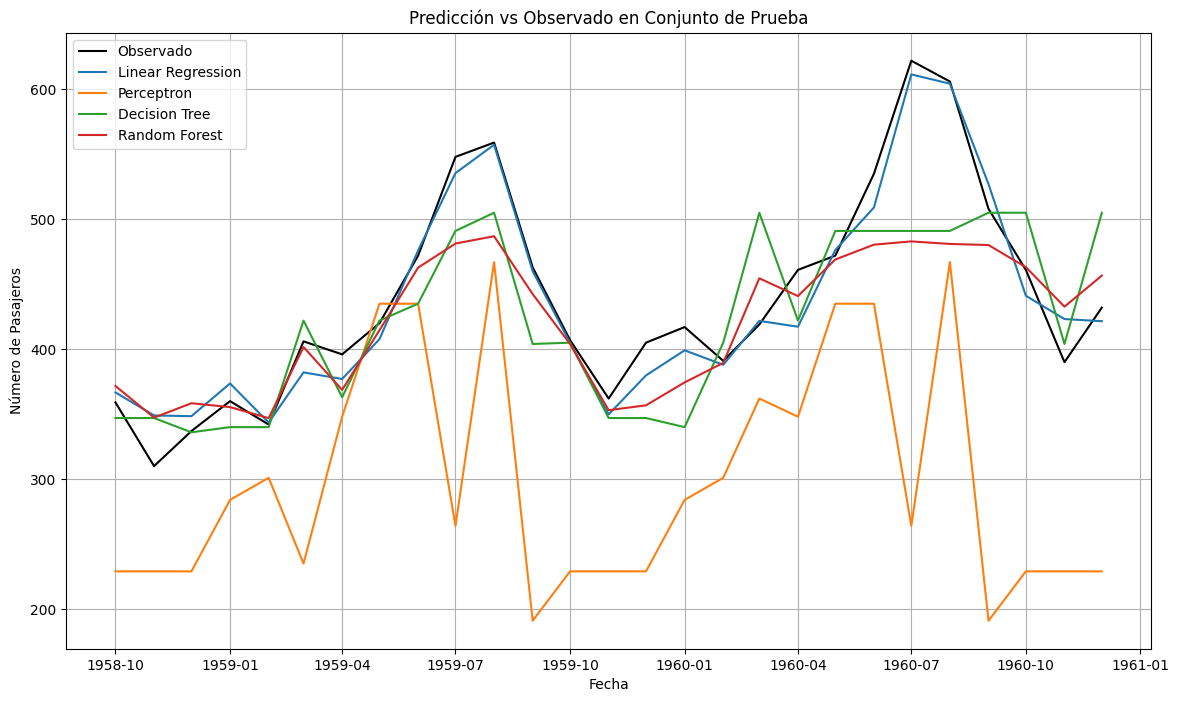

In [14]:
# Visualización de Predicciones
plt.figure(figsize=(14, 8))
plt.plot(series.index[-len(test):], test_y, label='Observado', color='black')

for name, model in models.items():
    test_pred = model.predict(test_X)
    plt.plot(series.index[-len(test):], test_pred, label=name)

plt.title('Predicción vs Observado en Conjunto de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.legend()
plt.grid(True)
plt.show()

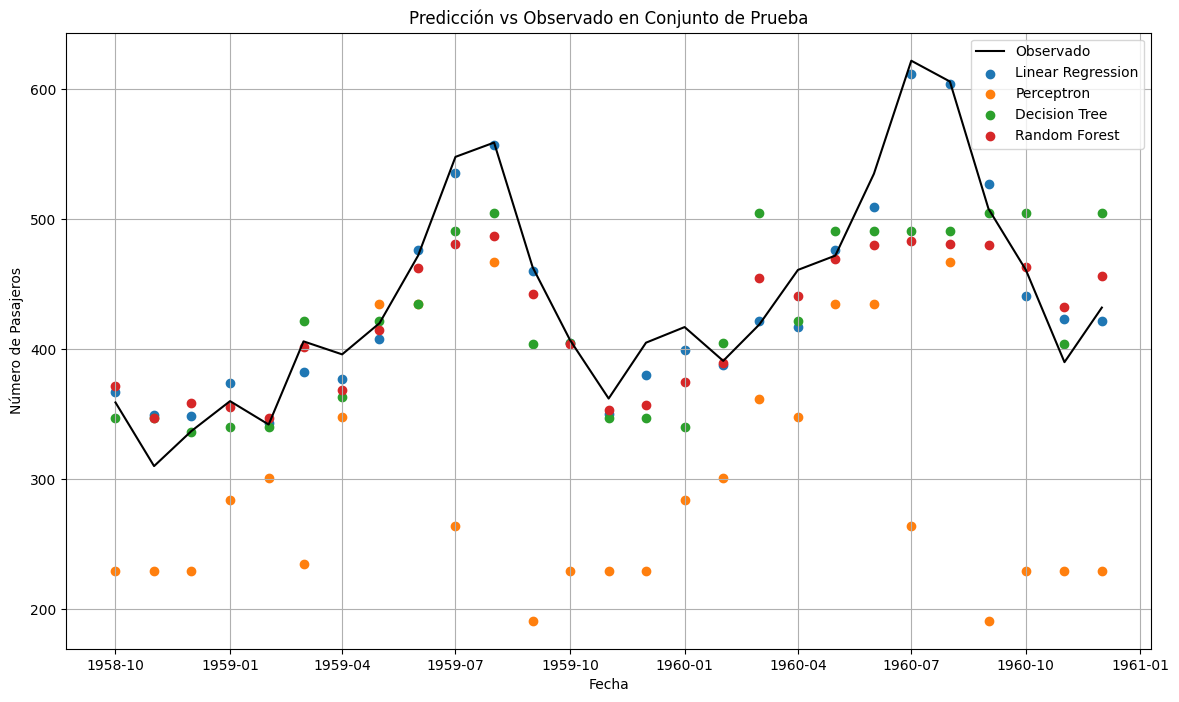

In [15]:
# Visualización de Predicciones
plt.figure(figsize=(14, 8))
plt.plot(series.index[-len(test):], test_y, label='Observado', color='black')

for name, model in models.items():
    test_pred = model.predict(test_X)
    plt.scatter(series.index[-len(test):], test_pred, label=name)

plt.title('Predicción vs Observado en Conjunto de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller

# Realizar la prueba ADF
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretación de los resultados
if result[1] < 0.05:
    print("La serie es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La serie no es estacionaria (no rechazamos la hipótesis nula).")


ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
La serie no es estacionaria (no rechazamos la hipótesis nula).


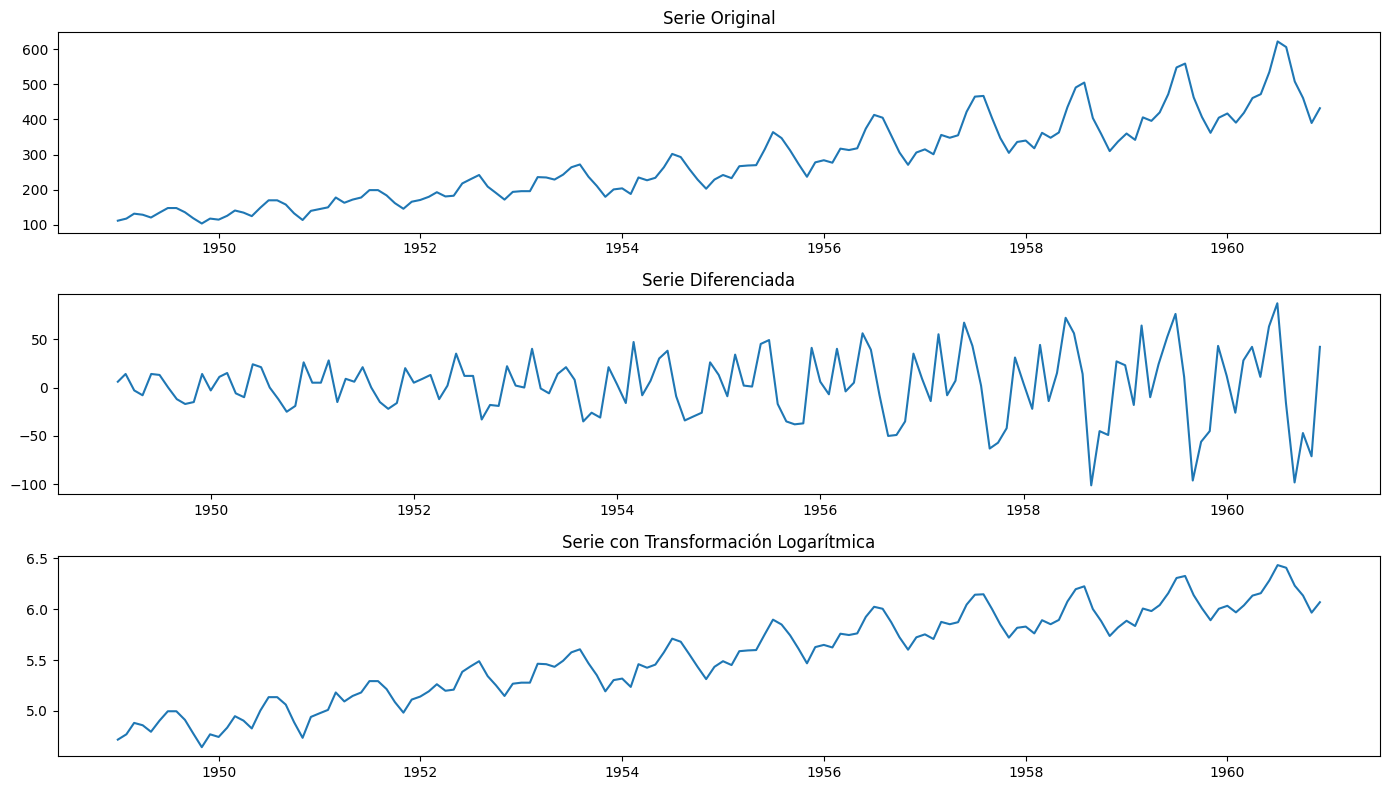

In [17]:
# Diferenciación
diff_series = series.diff().dropna()

# Transformación Logarítmica
log_series = np.log(series)

# Plot de la serie original, diferenciada y logarítmica
plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(series)
plt.title('Serie Original')

plt.subplot(3, 1, 2)
plt.plot(diff_series)
plt.title('Serie Diferenciada')

plt.subplot(3, 1, 3)
plt.plot(log_series)
plt.title('Serie con Transformación Logarítmica')

plt.tight_layout()
plt.show()


In [18]:
from statsmodels.tsa.stattools import adfuller

# Realizar la prueba ADF
result = adfuller(diff_series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretación de los resultados
if result[1] < 0.05:
    print("La serie de Diferenciación es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La serie de Diferenciación no es estacionaria (no rechazamos la hipótesis nula).")


ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
La serie de Diferenciación no es estacionaria (no rechazamos la hipótesis nula).


In [19]:
from statsmodels.tsa.stattools import adfuller

# Realizar la prueba ADF
result = adfuller(log_series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretación de los resultados
if result[1] < 0.05:
    print("La serie de Transformación Logarítmica es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La serie de Transformación Logarítmica no es estacionaria (no rechazamos la hipótesis nula).")


ADF Statistic: -1.717017
p-value: 0.422367
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
La serie de Transformación Logarítmica no es estacionaria (no rechazamos la hipótesis nula).
